# Deltas for Computational Speed-up

## Imports

In [1]:
import numpy as np
np.random.seed(42)
import pandas as pd
import math
import seaborn as sns
import random
random.seed(42)
import time
import heapq
from sortedcontainers import SortedList

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
TSPA_PATH = "../data/TSPA.csv"
TSPB_PATH = "../data/TSPB.csv"

In [3]:
df = pd.read_csv(TSPA_PATH, sep=";", header=None)
df.columns = ["x", "y", "val"]
df

,x,y,val
0,1355,1796,496
1,2524,387,414
2,2769,430,500
3,3131,1199,1133
4,661,87,903
...,...,...,...
195,189,1151,1145
196,3688,759,727
197,973,984,1637
198,910,1383,1255


In [4]:
def math_round(n):
    '''
    Mathematically rounds up to the nearest integer, always rounds up for 0.5

    ParametersL
    n: floating point number to round
    '''
    if n - math.floor(n) < 0.5:
        return math.floor(n)
    return math.ceil(n)

In [5]:
def plot_nodes_with_lines(df, connections=None):
    """
    Plots nodes with optional lines connecting them, using a color scale to represent values.
    
    Parameters:
    df: DataFrame of nodes, each with 'x', 'y', and 'val'.
    connections: list of node indices in the DataFrame to connect in order.
    """
    plt.figure(figsize=(14, 7))
    norm = plt.Normalize(vmin=df.val.min(), vmax=df.val.max())
    colors = cm.Reds(norm(df.val))
    scatter = plt.scatter(df.x, df.y, c=df.val, cmap='Reds', s=100, edgecolors='black')

    if connections is not None:
        for start, end in zip(connections[:-1], connections[1:]):
            plt.plot([df.x[start], df.x[end]], [df.y[start], df.y[end]], color='blue')
        plt.plot([df.x[connections[-1]], df.x[connections[0]]], [df.y[connections[-1]], df.y[connections[0]]], color='blue')
    cbar = plt.colorbar(scatter)
    cbar.set_label('Node Cost')

    plt.xlabel('X')
    plt.ylabel('Y')
    title = 'Nodes with Color-Scaled Values' if connections is None else 'Nodes with Values and Connections'
    plt.title(title)
    plt.grid(False)
    plt.show()


def get_distance_matrix(df, distance_function):
    """
    Calculates the distance matrix for a set of nodes using the given distance function.

    Parameters:
    nodes: DataFrame of nodes, each with 'x', 'y', and 'val'.
    distance_function: function that takes two points (x1, y1) and (x2, y2) and returns the distance.

    Returns:
    A 2D numpy array representing the distance matrix.
    """
    positions = df[["x", "y"]]
    num_nodes = len(positions)
    distance_matrix = np.zeros((num_nodes, num_nodes), dtype=np.int64)

    for i in range(num_nodes):
        for j in range(i, num_nodes):
            dist = round(distance_function(positions.iloc[i], positions.iloc[j]))
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    return distance_matrix


def calculate_score(solution, matrix, weights):
    '''
    Calculates solution score based on the matrix of distances and provided weights array.

    Parameters:
    solution: List or array of the solution
    matrix: Numpy array with node distances (2D)
    weights: Numpy array with node weights (1D - vector)
    '''
    score = 0
    for i in range(len(solution)-1):
        node_1 = solution[i]
        node_2 = solution[i+1]
        score += (matrix[node_1][node_2] + weights[node_1])
    node_1 = solution[-1]
    node_2 = solution[0]
    score += (matrix[node_1][node_2] + weights[node_1])
    return score

def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

In [6]:
def random_solution(distance_matrix, weights, start_node):
    '''
    Returns a random solution to the TSP problem based on the provided distance matrix.

    Parameters:
    distance_matrix: numpy.array containing distances between the nodes.
    weights: numpy.array containing the weights associated with each node.
    start_node: int, the index of the node from which the cycle starts.
    '''

    remaining_nodes = list(range(len(distance_matrix)))
    remaining_nodes.remove(start_node)
    np.random.shuffle(remaining_nodes)
    solution = [start_node] + remaining_nodes[:len(distance_matrix)//2 - 1]
    score = calculate_score(solution, distance_matrix, weights)
    return solution, score

In [7]:
distance_matrix = get_distance_matrix(df, euclidean_distance)
pd.DataFrame(distance_matrix)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0,1831,1966,1874,1845,1097,1658,2297,2193,1364,...,1977,746,1414,993,1527,1333,2553,897,607,1100
1,1831,0,249,1014,1887,1985,802,1872,1270,1027,...,2173,2104,2213,2215,1016,2457,1222,1662,1897,2600
2,1966,249,0,850,2136,2209,1050,1698,1066,981,...,2421,2301,2447,2426,1264,2679,976,1880,2089,2796
3,1874,1014,850,0,2709,2513,1715,858,344,512,...,2976,2442,2809,2632,1861,2942,710,2169,2229,2907
4,1845,1887,2136,2709,0,888,1091,3487,3036,2396,...,288,1352,780,1214,874,1164,3101,950,1320,1632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1333,2457,2679,2942,1164,473,1834,3537,3286,2486,...,1087,587,384,342,1587,0,3521,802,757,523
196,2553,1222,976,710,3101,3068,2023,1124,517,1212,...,3384,3063,3338,3231,2227,3521,0,2724,2847,3545
197,897,1662,1880,2169,950,345,1113,2824,2513,1741,...,1085,529,649,563,890,802,2724,0,404,987
198,607,1897,2089,2229,1320,497,1462,2785,2569,1752,...,1409,216,807,419,1260,757,2847,404,0,708


In [8]:
weights = df.val.to_numpy()
weights[:2]

array([496, 414], dtype=int64)

## Random

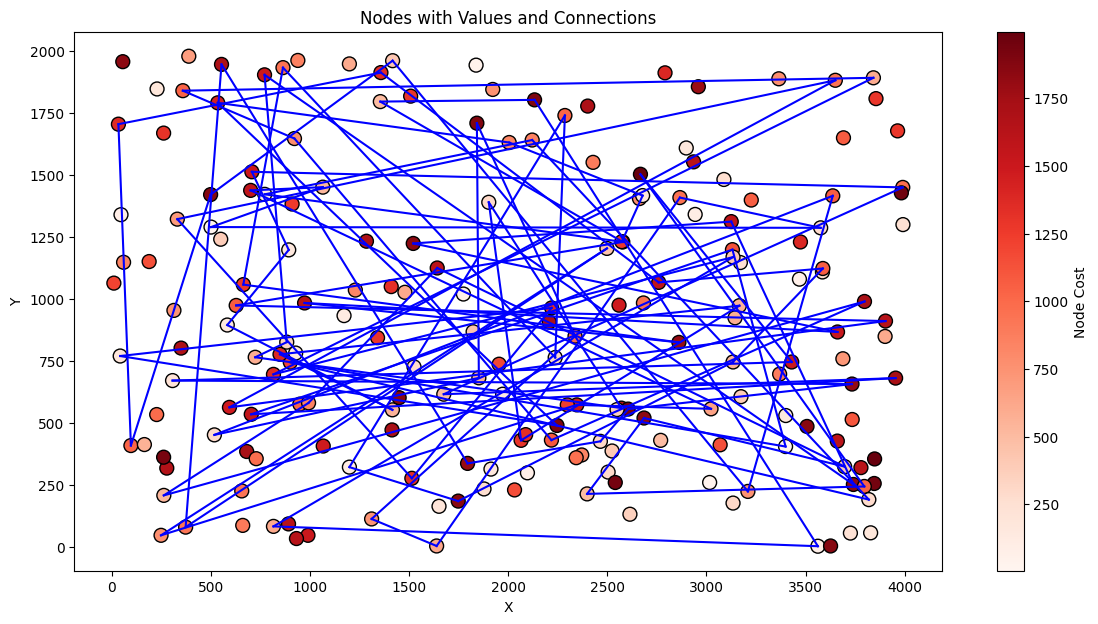

273509


In [9]:
start_solution, start_score = random_solution(distance_matrix, weights, start_node = 0)
plot_nodes_with_lines(df, start_solution)
print(start_score)

## Delta Steepest Search

Total time for 10 solutions: 5.458937168121338


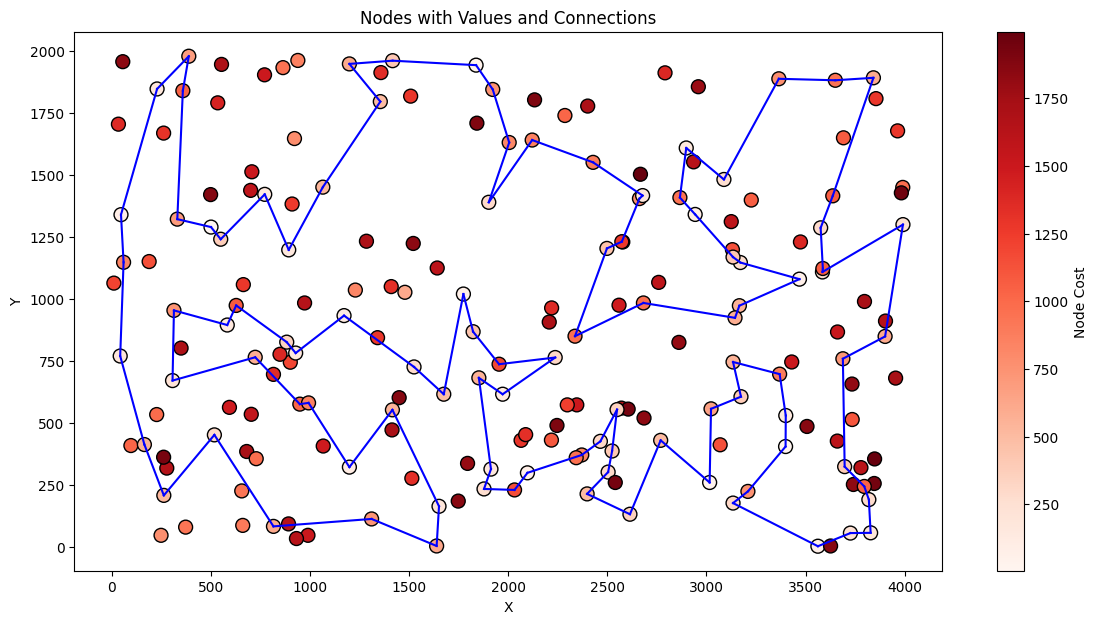

Achieved Total Score: 73982


In [10]:
def update_score_inter(score, solution, cycle_position, relative_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights):
    '''
    Calculates the score after changing the node with an outside node in remaining_nodes. Only used when a new move appears.
    '''
    node_1 = solution[cycle_position]
    node_2 = remaining_nodes[relative_node_position]
    node_before = solution[cycle_position - 1]
    node_after = solution[(cycle_position + 1) % num_cycle_nodes]
    score -= distance_matrix[node_1][node_before]
    score -= distance_matrix[node_1][node_after]
    score -= weights[node_1]
    score += distance_matrix[node_2][node_before]
    score += distance_matrix[node_2][node_after]
    score += weights[node_2]
    return score

def update_score_inter_edge(temp_score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix):
    '''
    Calculates the score after changing the solution by exchanging edges. Only used when a new move appears.
    '''
    temp_score -= distance_matrix[solution[cycle_position]][solution[cycle_position+1]]
    temp_score -= distance_matrix[solution[any_node_position]][solution[(any_node_position + 1) % num_cycle_nodes]]

    temp_score += distance_matrix[solution[cycle_position]][solution[any_node_position]]
    temp_score += distance_matrix[solution[cycle_position+1]][solution[(any_node_position + 1) % num_cycle_nodes]]
    return temp_score

def node_intra_change_steepest_fast(move_score, score, solution, cycle_position, relative_node_position, remaining_nodes, solution_set, remaining_nodes_set, solution_index, remaining_nodes_index):
    '''
    Calculates the new solution and score after applying a move by exchanging node with a node from remaining_nodes. Also updates indexes and sets.
    '''
    solution_set.remove(solution[cycle_position])
    solution_set.add(remaining_nodes[relative_node_position])
    remaining_nodes_set.add(solution[cycle_position])
    remaining_nodes_set.remove(remaining_nodes[relative_node_position])
    solution_index[remaining_nodes[relative_node_position]] = cycle_position
    remaining_nodes_index[solution[cycle_position]] = relative_node_position
    solution[cycle_position], remaining_nodes[relative_node_position] = remaining_nodes[relative_node_position], solution[cycle_position]
    return score + move_score, solution, remaining_nodes, solution_set, remaining_nodes_set, solution_index, remaining_nodes_index

def edge_inter_change_steepest_fast(move_score, score, solution, cycle_position, any_node_position, solution_index):
    '''
    Calculates the new solution and score after applying a move by exchanging edges. Also updates indexes and sets.
    '''
    solution[cycle_position+1:any_node_position+1] = solution[cycle_position+1:any_node_position+1][::-1]
    for i in range(cycle_position + 1, any_node_position + 1):
        solution_index[solution[i]] = i
    return score + move_score, solution, solution_index

def get_initial_moves(solution, cycle_positions, remaining_positions, num_cycle_nodes, score, remaining_nodes, distance_matrix, weights):
    '''
    Produces the initial moves.
    '''
    moves = SortedList()
    already_added_inter = set()
    already_added_edges = set()

    for cycle_position in cycle_positions:
        for relative_node_position in range(len(remaining_positions)):
            temp_score = update_score_inter(score, solution, cycle_position, relative_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
            move_score = temp_score - score
            node_before = solution[cycle_position - 1]
            node_after = solution[(cycle_position + 1) % num_cycle_nodes]
            already_added_inter.add((solution[cycle_position], remaining_nodes[relative_node_position], node_before, node_after))
            if move_score >= 0:
                continue
            moves.add((move_score, (solution[cycle_position], remaining_nodes[relative_node_position], node_before, node_after), 0)) # 0 for intra

        for any_node_position in range(cycle_position + 2, num_cycle_nodes):
            if (cycle_position == 0 and any_node_position == num_cycle_nodes - 1):
                continue
            temp_score = update_score_inter_edge(score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
            move_score = temp_score - score
            node_context_1 = solution[(cycle_position + 1) % num_cycle_nodes]
            node_context_2 = solution[(any_node_position + 1) % num_cycle_nodes]
            already_added_edges.add((solution[cycle_position], solution[any_node_position], node_context_1, node_context_2))
            if move_score >= 0:
                continue
            moves.add((move_score, (solution[cycle_position], solution[any_node_position], node_context_1, node_context_2), 1)) # 1 for inter

    return moves, already_added_inter, already_added_edges

def update_moves_intra(score, solution, moves, already_added_inter, already_added_edges, cycle_position, remaining_positions, remaining_nodes, num_cycle_nodes, distance_matrix, weights):
    '''
    Updates moves after an echange of nodes.
    '''
    for relative_node_position in range(len(remaining_positions)):
        prev_node = solution[cycle_position - 1]
        next_node = solution[(cycle_position + 1) % num_cycle_nodes]
        if (solution[cycle_position], remaining_nodes[relative_node_position], prev_node, next_node) in already_added_inter:
            continue
        temp_score = update_score_inter(score, solution, cycle_position, relative_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
        move_score = temp_score - score
        already_added_inter.add((solution[cycle_position], remaining_nodes[relative_node_position], prev_node, next_node))
        if move_score >= 0:
            continue
        moves.add((move_score, (solution[cycle_position], remaining_nodes[relative_node_position], prev_node, next_node), 0))

    for any_node_position in range(cycle_position + 2, num_cycle_nodes):
        if (cycle_position == 0 and any_node_position == num_cycle_nodes - 1):
            continue
        node_context_1 = solution[(cycle_position + 1) % num_cycle_nodes]
        node_context_2 = solution[(any_node_position + 1) % num_cycle_nodes]
        if (solution[cycle_position], solution[any_node_position], node_context_1, node_context_2) in already_added_edges:
            continue
        temp_score = update_score_inter_edge(score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
        move_score = temp_score - score
        already_added_edges.add((solution[cycle_position], solution[any_node_position], node_context_1, node_context_2))
        if move_score >= 0:
            continue
        moves.add((move_score, (solution[cycle_position], solution[any_node_position], node_context_1, node_context_2), 1))
        
    return moves, already_added_inter, already_added_edges

def update_moves_inter_edge(score, cycle_positions, solution, moves, num_cycle_nodes, distance_matrix, remaining_nodes, already_added_inter, already_added_edges, remaining_positions, weights):
    '''
    Updates the moves after an exchange of edges.
    '''
    for cycle_position in cycle_positions:
        for any_node_position in range(cycle_position + 2, num_cycle_nodes):
            if (cycle_position == 0 and any_node_position == num_cycle_nodes - 1):
                continue
            node_context_1 = solution[(cycle_position + 1) % num_cycle_nodes]
            node_context_2 = solution[(any_node_position + 1) % num_cycle_nodes]
            if (solution[cycle_position], solution[any_node_position], node_context_1, node_context_2) in already_added_edges:
                continue
            temp_score = update_score_inter_edge(score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
            move_score = temp_score - score
            already_added_edges.add((solution[cycle_position], solution[any_node_position], node_context_1, node_context_2))
            if move_score >= 0:
                continue
            moves.add((move_score, (solution[cycle_position], solution[any_node_position], node_context_1, node_context_2), 1))

    for cycle_position in cycle_positions:
        for relative_node_position in range(len(remaining_positions)):
            prev_node = solution[cycle_position - 1]
            next_node = solution[(cycle_position + 1) % num_cycle_nodes]
            if (solution[cycle_position], remaining_nodes[relative_node_position], prev_node, next_node) in already_added_inter:
                continue
            temp_score = update_score_inter(score, solution, cycle_position, relative_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
            move_score = temp_score - score
            already_added_inter.add((solution[cycle_position], remaining_nodes[relative_node_position], prev_node, next_node))
            if move_score >= 0:
                continue
            moves.add((move_score, (solution[cycle_position], remaining_nodes[relative_node_position], prev_node, next_node), 0))

    return moves, already_added_inter, already_added_edges

def init_index_dict(values):
    '''
    Creates a dictionary of of indexes for each value.
    '''
    index_dict = {}
    for i in range(len(values)):
        index_dict[values[i]] = i
    return index_dict

def deltas_steepest_local_search_edges(solution, score, distance_matrix, weights):
    num_cycle_nodes = len(solution)
    all_node_positions = [i for i in range(len(weights))]
    cycle_positions = [i for i in range(num_cycle_nodes)]
    remaining_nodes = list(set(all_node_positions) - set(solution))
    remaining_positions = list(set(all_node_positions) - set(cycle_positions))
    solution_set = set(solution)
    remaining_nodes_set = set(remaining_nodes)
    solution_index = init_index_dict(solution)
    remaining_nodes_index = init_index_dict(remaining_nodes)

    moves, already_added_inter, already_added_edges = get_initial_moves(solution, cycle_positions, remaining_positions, num_cycle_nodes, score, remaining_nodes, distance_matrix, weights)
    while True:
        i = 0
        while i < len(moves):
            move_score, move, inter = moves[i]
            if not inter:
                cycle_node, any_node, node_before, node_after = move
                if cycle_node not in solution_set or any_node not in remaining_nodes_set:
                    moves.remove(moves[i])
                    already_added_inter.remove(move)
                    continue
                cycle_position = solution_index[cycle_node]
                if node_before != solution[cycle_position - 1] or node_after != solution[(cycle_position + 1) % num_cycle_nodes]:
                    moves.remove(moves[i])
                    already_added_inter.remove(move)
                    continue
                relative_node_position = remaining_nodes_index[any_node]
                score, solution, remaining_nodes, solution_set, remaining_nodes_set, solution_index, remaining_nodes_index = node_intra_change_steepest_fast(move_score, score, solution, cycle_position, relative_node_position, remaining_nodes, solution_set, remaining_nodes_set, solution_index, remaining_nodes_index)
                moves, already_added_inter, already_added_edges = update_moves_intra(score, solution, moves, already_added_inter, already_added_edges, cycle_position, remaining_positions, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
                i = 0
            else:
                if move[0] not in solution_set or move[1] not in solution_set:
                    moves.remove(moves[i])
                    already_added_edges.remove(move)
                    continue
                cycle_node, any_node, node_after_cycle, node_after_any = move
                cycle_position = solution_index[cycle_node]
                any_node_position = solution_index[any_node]
                if cycle_position > any_node_position:
                    i += 1
                    continue # We got turned around ;(
                if node_after_cycle != solution[(cycle_position + 1) % num_cycle_nodes] or node_after_any != solution[(any_node_position + 1) % num_cycle_nodes]:
                    moves.remove(moves[i])
                    already_added_edges.remove(move)
                    continue
                score, solution, solution_index = edge_inter_change_steepest_fast(move_score, score, solution, cycle_position, any_node_position, solution_index)
                moves, already_added_inter, already_added_edges = update_moves_inter_edge(score, cycle_positions, solution, moves, num_cycle_nodes, distance_matrix, remaining_nodes, already_added_inter, already_added_edges, remaining_positions, weights)
                i = 0

        return solution, score

start_time = time.time()
for i in range(10):
    random_solution_result, random_solutionscore = random_solution(distance_matrix, weights, start_node = i)
    random_solution_result, random_solutionscore = deltas_steepest_local_search_edges(random_solution_result, random_solutionscore, distance_matrix, weights)
end_time = time.time()


print(f"Total time for 10 solutions: {end_time - start_time}")
start_solution, start_score = random_solution(distance_matrix, weights, start_node = 0)
solution, score = deltas_steepest_local_search_edges(start_solution, start_score, distance_matrix, weights)
plot_nodes_with_lines(df, solution)
print(f"Achieved Total Score: {score}")

## Experiments

In [11]:
def test_algorithm(algorithm, distance_matrix, weights, local_algorithm = None):
    '''
    Tests chosen algorithm for each node.

    Parameters:
    local_algorithm: function of the local search
    algorithm: Function to test
    distance_matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing the weights associated with each node.
    num_runs: integer, number of tests per node (default: 200)
    '''
    all_nodes = [i for i in range(len(weights))]
    results = {}
    intermidiate_results = {}
    solutions = {}
    times = []
    for node in all_nodes:
        solution, score = algorithm(distance_matrix, weights, node)
        intermidiate_results[node] = score
        if local_algorithm is not None:
            start_time = time.time()
            solution, score = local_algorithm(solution, score, distance_matrix, weights)
            end_time = time.time()
            times.append(end_time - start_time)
        solutions[node] = solution
        results[node] = score
    return solutions, intermidiate_results, results, times

In [12]:
del df
del weights
del distance_matrix

In [13]:
df_A = pd.read_csv(TSPA_PATH, sep=";", header=None)
df_A.columns = ["x", "y", "val"]
distance_matrix_A = get_distance_matrix(df_A, euclidean_distance)
weights_A = df_A.val.to_numpy()

In [14]:
random_steepest_deltas_solution_A, random_steepest_deltas_intermidiate_A, random_steepest_deltas_result_A, random_steepest_deltas_times_A = test_algorithm(random_solution, distance_matrix_A, weights_A, local_algorithm = deltas_steepest_local_search_edges)

In [15]:
df_B = pd.read_csv(TSPB_PATH, sep=";", header=None)
df_B.columns = ["x", "y", "val"]
distance_matrix_B = get_distance_matrix(df_B, euclidean_distance)
weights_B = df_B.val.to_numpy()

In [16]:
random_steepest_deltas_solution_B, random_steepest_deltas_intermidiate_B, random_steepest_deltas_result_B, random_steepest_deltas_times_B = test_algorithm(random_solution, distance_matrix_B, weights_B, local_algorithm = deltas_steepest_local_search_edges)

In [17]:
def plot_nodes_with_lines_and_score(df, score, connections=None):
    """
    Plots nodes with optional lines connecting them, using a color scale to represent values.
    
    Parameters:
    df: DataFrame of nodes, each with 'x', 'y', and 'val'.
    connections: list of node indices in the DataFrame to connect in order.
    """
    plt.figure(figsize=(14, 7))
    norm = plt.Normalize(vmin=df.val.min(), vmax=df.val.max())
    colors = cm.Reds(norm(df.val))
    scatter = plt.scatter(df.x, df.y, c=df.val, cmap='Reds', s=100, edgecolors='black')

    if connections is not None:
        for start, end in zip(connections[:-1], connections[1:]):
            plt.plot([df.x[start], df.x[end]], [df.y[start], df.y[end]], color='blue')
        plt.plot([df.x[connections[-1]], df.x[connections[0]]], [df.y[connections[-1]], df.y[connections[0]]], color='blue')
    cbar = plt.colorbar(scatter)
    cbar.set_label('Node Cost')

    plt.xlabel('X')
    plt.ylabel('Y')
    title = f'Nodes with Color-Scaled Values, Score: {score}' if connections is None else f'Nodes with Color-Scaled Values, Score: {score}'
    plt.title(title)
    plt.grid(False)
    plt.show()

def plot_score_distribution(score_dict, label, title, x_label):
    all_scores = []
    if type(score_dict) == dict:
        for key in score_dict.keys():
            item = score_dict[key]
            all_scores.append(item)
    else:
        all_scores = score_dict
    plt.hist(all_scores, bins=30, density=True, edgecolor='black', color="black", alpha=0.7)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel('Relative Frequency')
    plt.show()

def plot_score_distributions(score_dict_1, score_dict_2, labels, title = 'Continuous Distribution of Scores Across Different Nodes', x_label = 'Score Value'):
    all_scores_1 = []
    for key in score_dict_1.keys():
        item = score_dict_1[key]
        all_scores_1.append(item)

    all_scores_2 = []
    for key in score_dict_2.keys():
        item = score_dict_2[key]
        all_scores_2.append(item)
    
    plt.figure(figsize=(10, 6))
    
    sns.kdeplot(all_scores_1, label=labels[0], color='black', linewidth=2)
    sns.kdeplot(all_scores_2, label=labels[1], color='red', linewidth=2)
    plt.xscale('log')
    
    # Add titles and labels\
    plt.title(title, fontsize=14)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(loc='upper right')
    plt.show()

In [18]:
def plot_best_overall(df, solutions, results):
    all_scores = []
    for key in results.keys():
        item = results[key]    
        all_scores.append(item)
    
    all_solutions = []
    for key in solutions.keys():
        item = solutions[key]
        all_solutions.append(item) 
    
    all_scores = np.array(all_scores)
    best_overall = np.argmin(all_scores)
    best_solution = all_solutions[best_overall]
    print("___________________________________________________________________")
    print(f"For Node: {best_overall}")
    plot_nodes_with_lines_and_score(df, all_scores[best_overall], best_solution)
    print(f"Best solution: {best_solution}")

def plot_average_overall(df, solutions, results):
    all_scores = []
    for key in results.keys():
        item = results[key]    
        all_scores.append(item)
    
    all_solutions = []
    for key in solutions.keys():
        item = solutions[key]
        all_solutions.append(item)

    all_scores = np.array(all_scores)
    median_index = np.argsort(all_scores)[len(all_scores) // 2]
    median_solution = all_solutions[median_index]
    
    print("___________________________________________________________________")
    print(f"For Node: {median_index}")
    plot_nodes_with_lines_and_score(df, all_scores[median_index], median_solution)

def plot_worst_overall(df, solutions, results):
    all_scores = []
    for key in results.keys():
        item = results[key]    
        all_scores.append(item)
    
    all_solutions = []
    for key in solutions.keys():
        item = solutions[key]
        all_solutions.append(item)
    
    all_scores = np.array(all_scores)
    best_overall = np.argmax(all_scores)
    best_solution = all_solutions[best_overall]
    print("___________________________________________________________________")
    print(f"For Node: {best_overall}")
    plot_nodes_with_lines_and_score(df, all_scores[best_overall], best_solution)


def calculate_stats_overall(results):
    all_scores = []
    if type(results) == dict:
        for key in results.keys():
            all_scores.append(results[key])
    else:
        all_scores = results
    all_scores = np.array(all_scores)
    min_value = np.min(all_scores)
    max_value = np.max(all_scores)
    median_value = np.median(all_scores)
    mean_value = np.mean(all_scores)
    std_deviation = np.std(all_scores)
    return min_value, max_value, median_value, mean_value, std_deviation


def plot_node(df, scores, solutions, node):
    score = scores[node]
    connections = solutions[node]
    print(f"Plotting Node: {node}")
    plot_nodes_with_lines_and_score(df, score, connections)

def compare_improvement(result, improved_result):
    initial_results = []
    improved_results = []
    for key in result:
        val = result[key]
        initial_results.append(val)
        val = improved_result[key]
        improved_results.append(val)
    initial_arr = np.array(initial_results)
    improved_arr = np.array(improved_results)
    differences = initial_arr - improved_arr
    min_val = np.min(differences)
    max_val = np.max(differences)
    mean = np.mean(differences)
    median = np.median(differences)
    std = np.std(differences)
    relative = np.mean(differences/initial_arr)
    return min_val, max_val, mean, median, std, relative

### Delta Steepest

#### A

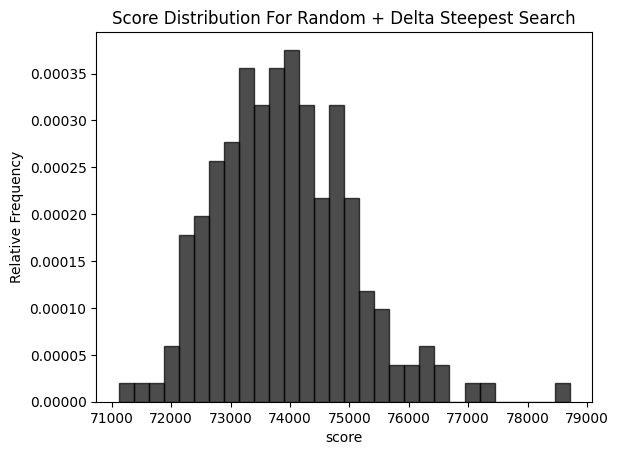

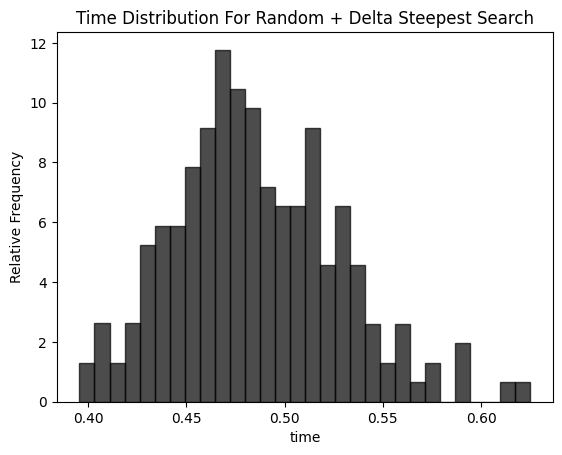

___________________________________________________________________
For Node: 159


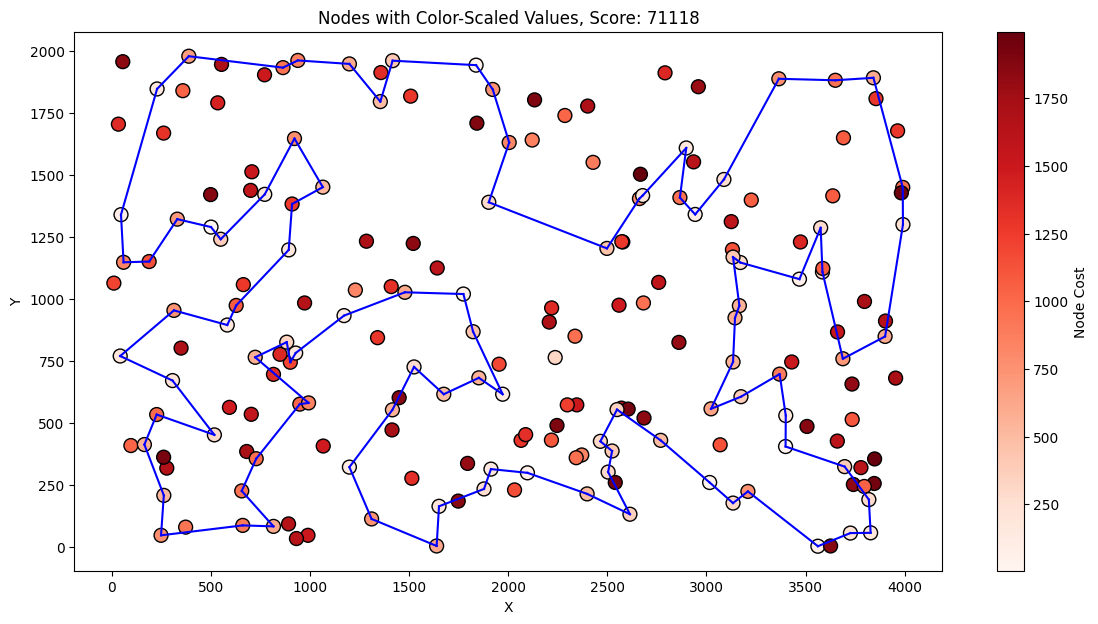

Best solution: [159, 193, 41, 139, 68, 46, 198, 115, 5, 42, 181, 34, 160, 184, 48, 54, 177, 10, 4, 112, 84, 35, 131, 149, 43, 116, 47, 65, 59, 51, 176, 80, 63, 79, 133, 151, 162, 123, 127, 70, 135, 154, 180, 53, 86, 75, 101, 1, 97, 152, 2, 120, 44, 25, 16, 171, 175, 113, 31, 78, 145, 179, 92, 129, 57, 55, 52, 178, 106, 185, 165, 40, 196, 81, 90, 27, 164, 7, 21, 14, 49, 102, 144, 62, 9, 148, 137, 23, 89, 183, 143, 0, 117, 93, 140, 108, 18, 22, 146, 195]


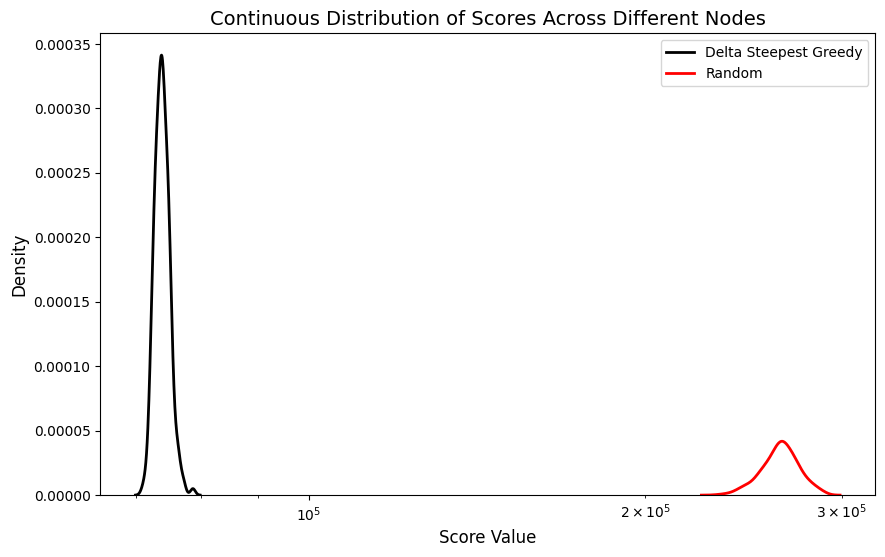

Overall Stats: 
 Minimum: 71118 Maximum: 78710 Median: 73829.5 Mean: 73910.425 Standard Deviation: 1139.8605416343703
Time Stats: 
 Minimum: 0.3956766128540039 Maximum: 0.625056266784668 Median: 0.4817570447921753 Mean: 0.4858424890041351 Standard Deviation: 0.042128207325491045
Comparison Stats: 
 Minimum: 160892 Maximum: 216004 Median: 191248.0 Mean: 190920.725 Standard Deviation: 10232.049869863566 and Relative: 0.7204865516356446


In [19]:
plot_score_distribution(random_steepest_deltas_result_A, label="Random + Delta Steepest Search", title = "Score Distribution For Random + Delta Steepest Search", x_label = "score")
plot_score_distribution(random_steepest_deltas_times_A, label="Times Random + Delta Steepest Search", title = "Time Distribution For Random + Delta Steepest Search", x_label = "time")
plot_best_overall(df_A, random_steepest_deltas_solution_A, random_steepest_deltas_result_A)
plot_score_distributions(random_steepest_deltas_result_A, random_steepest_deltas_intermidiate_A, labels = ["Delta Steepest Greedy", "Random"])
min_score, max_score, median_score, mean_score, std_score = calculate_stats_overall(random_steepest_deltas_result_A)
min_time, max_time, median_time, mean_time, std_time = calculate_stats_overall(random_steepest_deltas_times_A)
min_val, max_val, mean, median, std, relative = compare_improvement(random_steepest_deltas_intermidiate_A, random_steepest_deltas_result_A)
print(f"Overall Stats: \n Minimum: {min_score} Maximum: {max_score} Median: {median_score} Mean: {mean_score} Standard Deviation: {std_score}")
print(f"Time Stats: \n Minimum: {min_time} Maximum: {max_time} Median: {median_time} Mean: {mean_time} Standard Deviation: {std_time}")
print(f"Comparison Stats: \n Minimum: {min_val} Maximum: {max_val} Median: {median} Mean: {mean} Standard Deviation: {std} and Relative: {relative}")

#### B

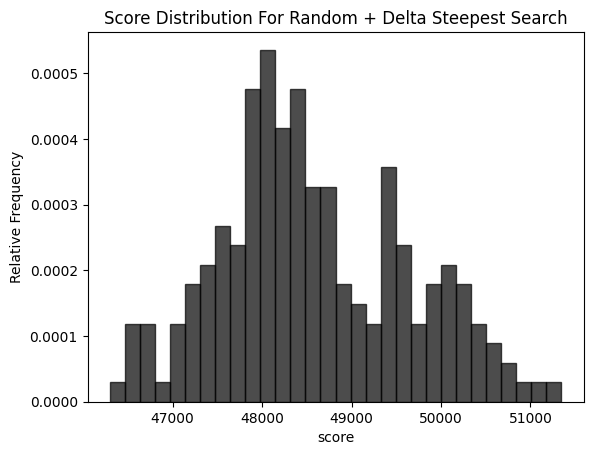

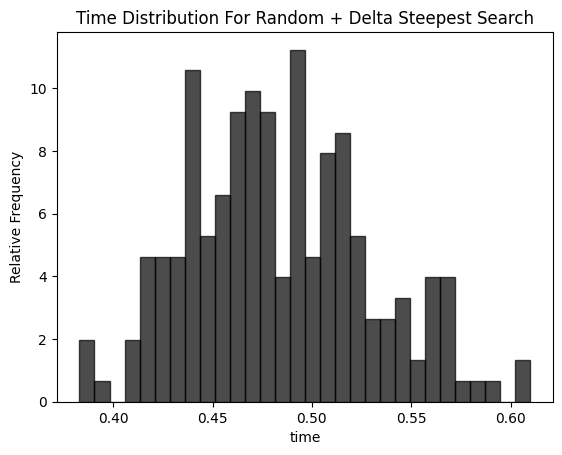

___________________________________________________________________
For Node: 106


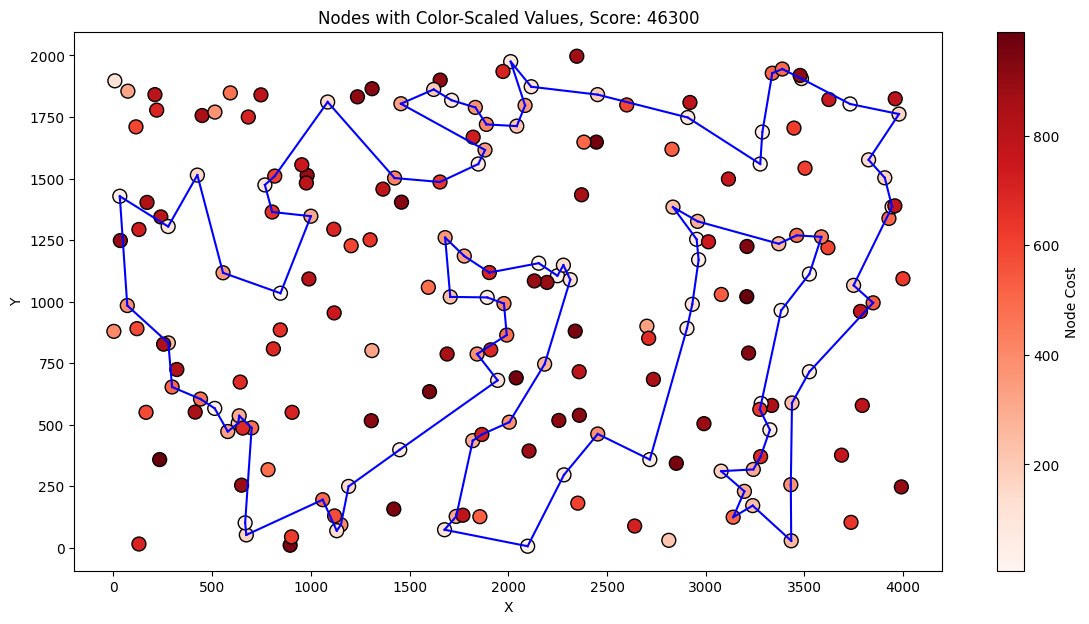

Best solution: [106, 153, 81, 77, 141, 36, 61, 21, 87, 82, 111, 35, 109, 0, 29, 49, 11, 139, 138, 33, 160, 144, 104, 8, 177, 5, 78, 175, 45, 80, 190, 73, 54, 31, 193, 117, 198, 156, 1, 38, 63, 135, 122, 131, 121, 51, 125, 90, 191, 147, 134, 43, 168, 195, 6, 188, 169, 132, 13, 145, 15, 70, 3, 155, 152, 183, 140, 4, 149, 28, 20, 60, 148, 47, 94, 179, 172, 166, 194, 114, 137, 127, 165, 89, 163, 103, 26, 113, 180, 176, 86, 185, 99, 130, 95, 55, 34, 18, 62, 124]


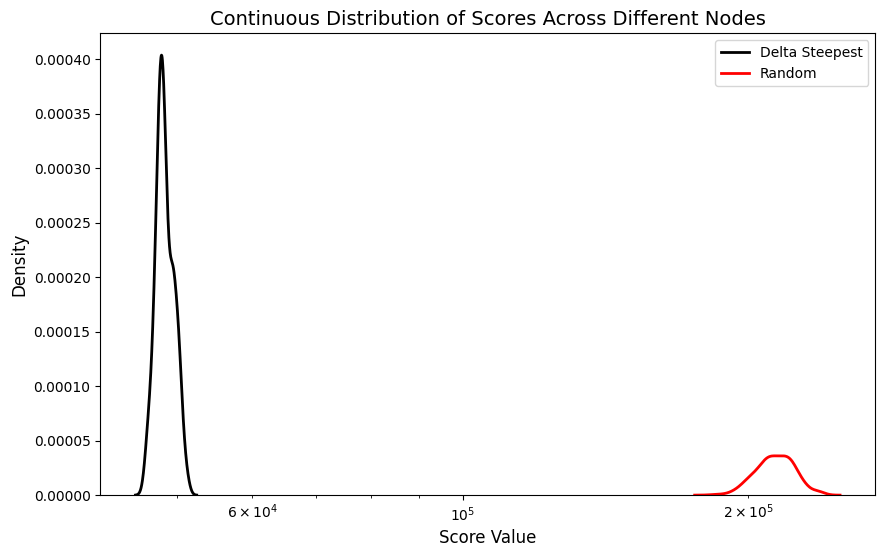

Overall Stats: 
 Minimum: 46300 Maximum: 51342 Median: 48380.0 Mean: 48574.165 Standard Deviation: 1051.0401837108798
Time Stats: 
 Minimum: 0.38301801681518555 Maximum: 0.609959602355957 Median: 0.4779583215713501 Mean: 0.48334038257598877 Standard Deviation: 0.045308177584561925
Comparison Stats: 
 Minimum: 137477 Maximum: 191657 Median: 166118.0 Mean: 165604.375 Standard Deviation: 9782.074328810582 and Relative: 0.7727390391862662


In [20]:
plot_score_distribution(random_steepest_deltas_result_B, label="Random + Delta Steepest Search", title = "Score Distribution For Random + Delta Steepest Search", x_label = "score")
plot_score_distribution(random_steepest_deltas_times_B, label="Times Random + Delta Steepest Search", title = "Time Distribution For Random + Delta Steepest Search", x_label = "time")
plot_best_overall(df_B, random_steepest_deltas_solution_B, random_steepest_deltas_result_B)
plot_score_distributions(random_steepest_deltas_result_B, random_steepest_deltas_intermidiate_B, labels = ["Delta Steepest", "Random"])
min_score, max_score, median_score, mean_score, std_score = calculate_stats_overall(random_steepest_deltas_result_B)
min_time, max_time, median_time, mean_time, std_time = calculate_stats_overall(random_steepest_deltas_times_B)
min_val, max_val, mean, median, std, relative = compare_improvement(random_steepest_deltas_intermidiate_B, random_steepest_deltas_result_B)
print(f"Overall Stats: \n Minimum: {min_score} Maximum: {max_score} Median: {median_score} Mean: {mean_score} Standard Deviation: {std_score}")
print(f"Time Stats: \n Minimum: {min_time} Maximum: {max_time} Median: {median_time} Mean: {mean_time} Standard Deviation: {std_time}")
print(f"Comparison Stats: \n Minimum: {min_val} Maximum: {max_val} Median: {median} Mean: {mean} Standard Deviation: {std} and Relative: {relative}")

In [21]:
def plot_all_distributions(score_dict_1, score_dict_2, score_dict_3, score_dict_4, labels):
    all_scores_1 = []
    for key in score_dict_1.keys():
        item = score_dict_1[key]
        all_scores_1.append(item)

    all_scores_2 = []
    for key in score_dict_2.keys():
        item = score_dict_2[key]
        all_scores_2.append(item)

    all_scores_3 = []
    for key in score_dict_3.keys():
        item = score_dict_3[key]
        all_scores_3.append(item)

    all_scores_4 = []
    for key in score_dict_4.keys():
        item = score_dict_4[key]
        all_scores_4.append(item)
    
    plt.figure(figsize=(18, 12))

    all_scores_1 = np.array(all_scores_1)
    all_scores_2 = np.array(all_scores_2)
    all_scores_3 = np.array(all_scores_3)
    all_scores_4 = np.array(all_scores_4)

    to_plot = [np.mean(all_scores_1), np.mean(all_scores_2), np.mean(all_scores_3), np.mean(all_scores_4)]
    sorted_indices = np.argsort(to_plot)[::-1]
    to_plot_sorted = np.array(to_plot)[sorted_indices]
    labels_sorted = np.array(labels)[sorted_indices]

    # Plotting the bar chart
    plt.figure(figsize=(12, 5))
    plt.yscale('log')
    plt.bar(labels_sorted, to_plot_sorted, color=['blue', 'red', 'green', 'black'])

    # Adding title and labels
    plt.title('Comparison of Mean Scores Across Different TSP Algorithms', fontsize=14)
    plt.xlabel('TSP Algorithms', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Mean Score Logarithmic Scale)', fontsize=12)

<Figure size 1800x1200 with 0 Axes>

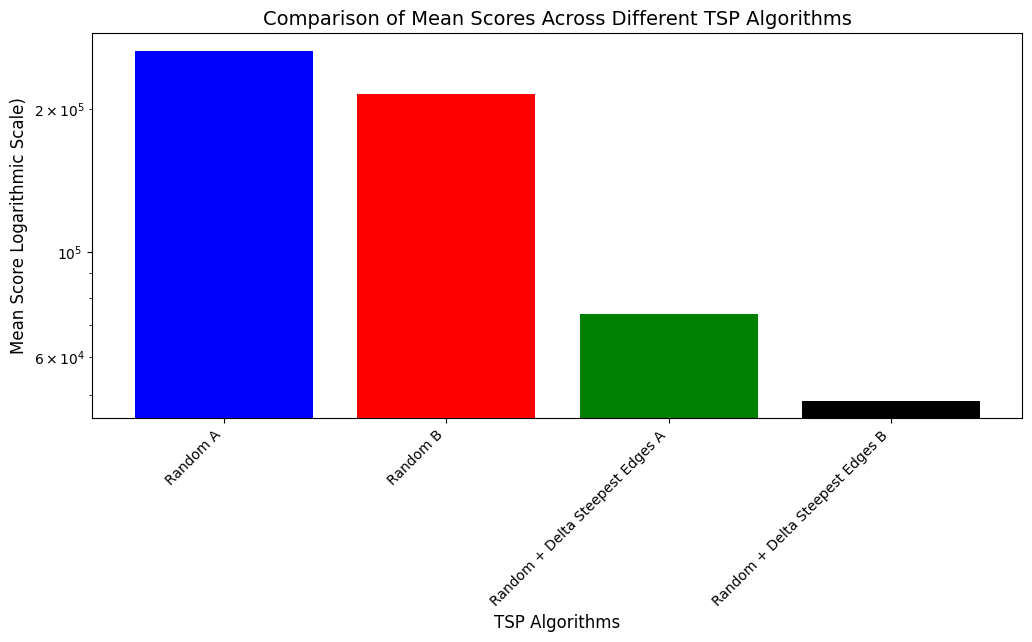

In [22]:
plot_all_distributions(random_steepest_deltas_result_A, random_steepest_deltas_result_B, random_steepest_deltas_intermidiate_A, random_steepest_deltas_intermidiate_B, labels = ["Random + Delta Steepest Edges A", "Random + Delta Steepest Edges B", "Random A", "Random B"])